<link rel="stylesheet" href="https://use.typekit.net/dvn1law.css">
<style>        
@font-face {
font-family:"futura-pt-bold";
src:url("https://use.typekit.net/af/053fc9/00000000000000003b9af1e4/27/l?primer=7cdcb44be4a7db8877ffa5c0007b8dd865b3bbc383831fe2ea177f62257a9191&fvd=n7&v=3") format("woff2"),url("https://use.typekit.net/af/053fc9/00000000000000003b9af1e4/27/d?primer=7cdcb44be4a7db8877ffa5c0007b8dd865b3bbc383831fe2ea177f62257a9191&fvd=n7&v=3") format("woff"),url("https://use.typekit.net/af/053fc9/00000000000000003b9af1e4/27/a?primer=7cdcb44be4a7db8877ffa5c0007b8dd865b3bbc383831fe2ea177f62257a9191&fvd=n7&v=3") format("opentype");
font-display:auto;font-style:normal;font-weight:700;font-stretch:normal;
}
</style>
<div style="display: flex; margin: 0px; padding-top: 1.5rem; padding-bottom: 1.5rem; font-family: futura-pt, 'Tahoma', 'Segoe UI', Geneva, Verdana, sans-serif;">
    <span style="margin-right: 15px; padding-right: 2rem; background-color: #3b6d48;"></span>
    <div style="margin-bottom: auto; margin-top: auto; margin-right: auto; padding-right: 15px;">
        <div style="margin: 0; padding-top: 0.2rem; padding-bottom: 3.3rem; letter-spacing: 0.15rem; color: #a6ce37; font-weight: bold; font-size: 3rem; font: futura-pt-bold"> CEOS Analytics Lab</div>
        <div style="margin: 0; color: #469ab9; font-weight: bold; font-size: 1.5rem;">Welcome to the CEOS Analytics Lab!</div>
        <div style="margin: 0; padding-bottom: 0.2rem; color: #474c38; font-size: 1.25rem;"><span>Tutorial</span><span>| </span><span style="color: #3b6d48; font-weight: bold;">Cleaning Data</span></div>
        <hr style="border: 1px solid #474c38;">
    </div>
    <div style="margin-top: auto; margin-bottom: auto; margin-left: auto; padding-left: 15px;">
        <div><img style="vertical-align: middle; padding: 0.5rem; width: 300px; height: auto;" src="https://ceos.org/document_management/Communications/CEOS-Logos/CEOS_logo_colour_no_text-small.png" /></div>
    </div>
</div>

# Introduction

In this tutorial we will clean Landsat 8 data and display a median mosaic of the cleaned dataset. 

# Tutorial

## Import Dependencies and Configure EASI

Begin by initializing CAL. Initializing CAL provides access to large library of convenience utilities that greatly simplify data analysis. After running this cell the output will show "Successfully found configuration for deployment 'eail'".

In [1]:
import sys, os
sys.path.append(os.path.expanduser('~/cal-notebooks/scripts'))
os.environ['USE_PYGEOS'] = '0'

### EASI tools
from easi_tools import EasiDefaults
from easi_tools import notebook_utils
easi = EasiDefaults() # Get the default parameters for this system

Successfully found configuration for deployment "eail"


## Select Area of Interest

Next, define the area of interest and display it on a map. Showing a map is a good first step in any notebook as it helps both us (the writers) and the readers visualize the area of interest. Notice the use of CAL's default area of interest and the convenience utility for displaying the map.

In [2]:
latitude = easi.latitude
longitude = easi.longitude

from dea_tools.plotting import display_map
display_map(longitude, latitude)

## Load Data

Now load the data. This may take some time. When the data is finished loading, you will see a summary of the dataset.

In [3]:
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)

import datacube
dc = datacube.Datacube()
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          time = ('2021-01-01', '2021-01-31'),
                          product = 'landsat8_c2l2_sr',
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                          output_crs = 'EPSG:6933',
                          resolution = (-30,30),
                         ) 
landsat_dataset

<xarray.Dataset>
Dimensions:      (time: 4, y: 342, x: 322)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T15:47:05.923026 ... 2021-01...
  * y            (y) float64 4.418e+06 4.418e+06 ... 4.408e+06 4.408e+06
  * x            (x) float64 -7.386e+06 -7.386e+06 ... -7.376e+06 -7.376e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 28924 25573 22874 ... 10476 10333 11220
    green        (time, y, x) uint16 28520 25031 22354 ... 10336 10114 10755
    blue         (time, y, x) uint16 30471 26444 22962 ... 10014 9539 10208
    nir          (time, y, x) uint16 29824 27220 24938 ... 16453 15246 13200
    swir1        (time, y, x) uint16 22405 21085 19979 ... 13655 13978 13813
    swir2        (time, y, x) uint16 19296 18216 17192 ... 11550 11795 12478
    pixel_qa     (time, y, x) uint16 22280 22280 22280 ... 21824 21824 21824
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Clean the data

Next, clean the data. Here, we again see the use of a CAL convenience utility for cleaning data. Data must be cleaned prior to performing any analysis so that invalid or unneeded data doesn't impact the results.

In [4]:
from datacube.utils import masking
clean_mask = masking.make_mask(landsat_dataset['pixel_qa'], clear='clear')
cleaned_landsat_dataset = landsat_dataset.where(clean_mask)
cleaned_landsat_dataset

<xarray.Dataset>
Dimensions:      (time: 4, y: 342, x: 322)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T15:47:05.923026 ... 2021-01...
  * y            (y) float64 4.418e+06 4.418e+06 ... 4.408e+06 4.408e+06
  * x            (x) float64 -7.386e+06 -7.386e+06 ... -7.376e+06 -7.376e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 nan nan nan ... 1.033e+04 1.122e+04
    green        (time, y, x) float32 nan nan nan ... 1.011e+04 1.076e+04
    blue         (time, y, x) float32 nan nan nan ... 9.539e+03 1.021e+04
    nir          (time, y, x) float32 nan nan nan ... 1.525e+04 1.32e+04
    swir1        (time, y, x) float32 nan nan nan ... 1.398e+04 1.381e+04
    swir2        (time, y, x) float32 nan nan nan ... 1.18e+04 1.248e+04
    pixel_qa     (time, y, x) float32 nan nan nan ... 2.182e+04 2.182e+04
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Create mosaic

After we have cleaned the data, we create a median mosaic.

In [5]:
from odc.algo import to_f32
from ceos_utils.data_cube_utilities.dc_mosaic import create_median_mosaic
landsat_composite = to_f32(create_median_mosaic(cleaned_landsat_dataset, clean_mask), scale=0.0000275, offset=0.2)
landsat_composite

/env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<xarray.Dataset>
Dimensions:      (y: 342, x: 322)
Coordinates:
  * y            (y) float64 4.418e+06 4.418e+06 ... 4.408e+06 4.408e+06
  * x            (x) float64 -7.386e+06 -7.386e+06 ... -7.376e+06 -7.376e+06
    spatial_ref  int32 6933
Data variables:
    red          (y, x) float32 0.4641 0.4652 0.4608 ... 0.4881 0.4842 0.5085
    green        (y, x) float32 0.4551 0.4557 0.4542 ... 0.4842 0.4781 0.4958
    blue         (y, x) float32 0.4403 0.4418 0.4405 ... 0.4754 0.4623 0.4807
    nir          (y, x) float32 0.5414 0.5695 0.5867 ... 0.6525 0.6193 0.563
    swir1        (y, x) float32 0.5375 0.5533 0.551 ... 0.5755 0.5844 0.5799
    swir2        (y, x) float32 0.4952 0.5021 0.4957 ... 0.5176 0.5244 0.5431
    pixel_qa     (y, x) float32 0.8002 0.8002 0.8002 ... 0.8002 0.8002 0.8002

## Display Results

Finally, display the mosaic. We have chosen a Landsat 8 band combination commonly used to vizualize urban areas.

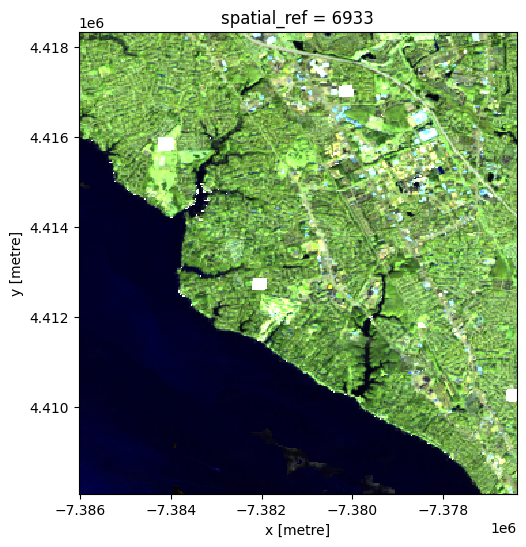

In [7]:
from dea_tools.plotting import rgb
rgb(landsat_composite, ['swir2', 'swir1', 'red'])

## Conclusion

You have successfully cleaned Landsat 8 data and used it to display a median mosaic

# Learn More

For more information, see the following

- The CAL Environment
- CAL Utilities
- EASI
- Loading data using ODC
- Data Cleaning Explained
- Mosaics
- Landsat 8 Band Combinations